<h1>TF Mutiple Hidden Layers: Regression on Boston Data
<br />
Batched, Parameterized, with Dropout</h1>
<br />
This is adapted from Frossard's <a href="http://www.cs.toronto.edu/~frossard/post/tensorflow/">tutorial</a>.
<br />
This approach is not batched, and the number of layers is fixed.
<br />
<br />
D. Thiebaut
<br />August 2016


<h2>Import the Libraries and Tools</h2>

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function

%matplotlib inline

<h2>Import the Boston Data</h2>
<br />
We don't worry about adding column names to the data.

In [18]:
boston = learn.datasets.load_dataset('boston')
#print( "boston = ", boston )
x, y = boston.data, boston.target
y.resize( y.size, 1 ) #make y = [[x], [x], [x], ... ]

train_x, test_x, train_y, test_y = model_selection.train_test_split(
                                    x, y, test_size=0.2, random_state=42)

print( "Dimension of Boston test_x = ", test_x.shape )
print( "Dimension of test_y = ", test_y.shape )

print( "Dimension of Boston train_x = ", train_x.shape )
print( "Dimension of train_y = ", train_y.shape )


Dimension of Boston test_x =  (102, 13)
Dimension of test_y =  (102, 1)
Dimension of Boston train_x =  (404, 13)
Dimension of train_y =  (404, 1)


We scale the inputs to have mean 0 and standard variation 1.

In [19]:
scaler = preprocessing.StandardScaler( )
train_x = scaler.fit_transform( train_x )
test_x  = scaler.fit_transform( test_x )

We verify that we have 13 features...

In [20]:
numFeatures =  train_x.shape[1] 

print( "number of features = ", numFeatures )

number of features =  13


<h2>Input & Output Place-Holders</h2>
<br />
Define 2 place holders to the graph, one for the inputs one for the outputs...

In [21]:
with tf.name_scope("IO"):
    inputs = tf.placeholder(tf.float32, [None, numFeatures], name="X")
    outputs = tf.placeholder(tf.float32, [None, 1], name="Yhat")

<h2>Define the Coeffs for the Layers</h2>
<br />
For each layer the input vector will be multiplied by a matrix $h$ of dim $n$ x $m$, where $n$ is the dimension of the input vector and $m$ the dimention of the output vector.   Then a bias vector of dimension $m$ is added to the product.

In [32]:
with tf.name_scope("LAYER"):
    # network architecture
    #Layers = [numFeatures, 52, 104, 52, 52, 52, 1]
    Layers = [numFeatures, 100, 100, 1]
    h = []
    b = []
    for i in range( 1, len( Layers ) ):
        h.append( tf.Variable(tf.random_normal([Layers[i-1], Layers[i]], 0, 0.1, dtype=tf.float32), name="h%d" % i ) )
        b.append( tf.Variable(tf.random_normal([Layers[i]], 0, 0.1, dtype=tf.float32 ), name="b%d" % i ) )
   
    dropout = 0.2 #0.990                           # Dropout, probability to keep units
    keep_prob = tf.placeholder(tf.float32)   # dropout (keep probability)


<h2>Define the Layer operations as a Python funtion</h2>

In [33]:
def model( inputs, h, b ):
    lastY = inputs
    for i, (hi, bi) in enumerate( zip( h, b ) ):
        y =  tf.add( tf.matmul( lastY, h[i]), b[i] )    
        
        if i==len(h)-1:
            return y
        
        lastY =  tf.nn.sigmoid( y )
        lastY =  tf.nn.dropout( lastY, dropout )

<h2>Define the operations that are performed</h2>
<br />
We define what happens to the inputs (x), when they are provided, and what we do with 
the outputs of the layers (compare them to the y values), and the type of minimization 
that must be done.

In [34]:
with tf.name_scope("train"):

    learning_rate = 0.01 #0.250
    #yout = model2( inputs, [h1, b1, h2, b2, h3, b3, hout, bout] )
    yout = model( inputs, h, b )
    
    cost_op = tf.reduce_mean( tf.pow( yout - outputs, 2 ))
    #cost_op = tf.reduce_sum( tf.pow( yout - outputs, 2 ))
    #cost_op =  tf.reduce_mean(-tf.reduce_sum( yout * tf.log( outputs ) ) )

    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)
    train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( cost_op )
    #train_op = tf.train.AdagradOptimizer( learning_rate=learning_rate ).minimize( cost_op )

<h2>Train the Model</h2>
<br />
We are now ready to go through many sessions, and in each one train the model.  Here we train on the whole x-train and y-train data, rather than batching into smaller groups.

In [35]:
# define variables/constants that control the training
epoch       = 0          # counter for number of rounds training network
last_cost   = 0          # keep track of last cost to measure difference
max_epochs  = 20000      # total number of training sessions
tolerance   = 1e-6       # we stop when diff in costs less than that
batch_size  = 20 #50         # we batch the data in groups of this size
num_samples = train_y.shape[0]                  # number of samples in training set
num_batches = int( num_samples / batch_size )   # compute number of batches, given 
                                                # batch size
    

print( "batch size = ", batch_size )
print( "test length= ", num_samples )
print( "number batches = ", num_batches )
print( "--- Beginning Training ---" )

sess = tf.Session() # Create TensorFlow session
with sess.as_default():
    
    # initialize the variables
    init = tf.initialize_all_variables()
    sess.run(init)
    
    # start training until we stop, either because we've reached the max
    # number of epochs, or successive errors are close enough to each other
    # (less than tolerance)
    
    costs = []
    epochs= []
    while True:
        # Do the training
        cost = 0
        for n in range(  num_batches ):
            batch_x = train_x[ n*batch_size : (n+1)*batch_size ]
            batch_y = train_y[ n*batch_size : (n+1)*batch_size ]
            sess.run( train_op, feed_dict={inputs: batch_x, outputs: batch_y} )
            c = sess.run(cost_op, feed_dict={inputs: batch_x, outputs: batch_y} )
            cost += c
        cost /= num_batches
        
        costs.append( cost )
        epochs.append( epoch )
            
        # Update the user every 1000 epochs
        if epoch % 1000==0:
            print( "Epoch: %d - Error diff: %1.8f" %(epoch, cost) )
            
            # time to stop?
            if epoch > max_epochs  or abs(last_cost - cost) < tolerance:
                print( "--- STOPPING ---" )
                break
            last_cost = cost
            
        epoch += 1
    
    # we're done...
    # print some statistics...
    
    print( "Test Cost =", sess.run(cost_op, feed_dict={inputs: test_x, outputs: test_y}) )

    # compute the predicted output for test_x
    pred_y = sess.run( yout, feed_dict={inputs: test_x, outputs: test_y} )
    
    print( "\nA few predictions versus real data from test set\nPrediction\nreal\tpredicted" )
    for (y, yHat ) in zip( test_y, pred_y )[0:10]:
        print( "%1.1f\t%1.1f" % (y, yHat ) )
    

batch size =  20
test length=  404
number batches =  20
--- Beginning Training ---
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0 - Error diff: 306.34641533
Epoch: 1000 - Error diff: 15.85769203
Epoch: 2000 - Error diff: 18.87189531
Epoch: 3000 - Error diff: 17.33074903
Epoch: 4000 - Error diff: 14.79419188
Epoch: 5000 - Error diff: 15.18685025
Epoch: 6000 - Error diff: 14.31060660
Epoch: 7000 - Error diff: 15.87763214
Epoch: 8000 - Error diff: 16.89319258
Epoch: 9000 - Error diff: 15.51707026
Epoch: 10000 - Error diff: 14.78556638
Epoch: 11000 - Error diff: 13.78513114
Epoch: 12000 - Error diff: 13.31853907
Epoch: 13000 - Error diff: 13.43012848
Epoch: 14000 - Error diff: 16.41246352
Epoch: 15000 - Error diff: 14.93687530
Epoch: 16000 - Error diff: 12.63519905
Epoch: 17000 - Error diff: 12.59978299
Epoch: 18000 - Error diff: 15.62091355
Epoch: 19000 - Error diff: 14.16743006
Epoch: 20000 - Error diff: 13.49176095
Epoch: 21000 - Error diff: 14.706733

TypeError: 'zip' object is not subscriptable

<h2>R2 score</h2>
<br />

In [36]:
r2 =  metrics.r2_score(test_y, pred_y) 
print( "mean squared error = ", metrics.mean_squared_error(test_y, pred_y))
print( "r2 score (coef determination) = ", metrics.r2_score(test_y, pred_y))

mean squared error =  24.0307471176
r2 score (coef determination) =  0.672310003902


<h2>Plot Prediction vs. Real Housing Price</h2>

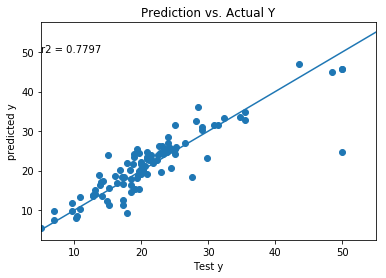

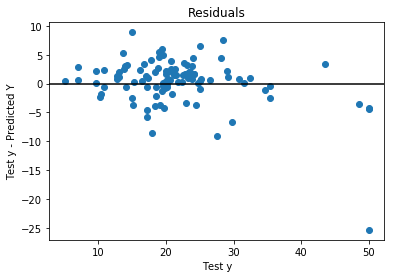

In [13]:
    
    fig = plt.figure()
    xmin = min(test_y) 
    xmax = max(test_y) + 5
    plt.xlim(xmin, xmax)

    x = np.linspace( xmin, xmax )
    plt.scatter( test_y, pred_y )
    plt.plot( x, x )
    
    plt.text(5, 50, r'r2 = %1.4f' % r2)
    plt.xlabel( "Test y" )
    plt.ylabel( "predicted y" )
    plt.title( "Prediction vs. Actual Y" )
    #plt.save( "images/sigmoid_adagrad_52_39_26_13_1.png")
    plt.show()
    fig.savefig('PredVsRealBoston.png', bbox_inches='tight')
    
    fig = plt.figure()
    plt.scatter( test_y, - test_y + pred_y )
    plt.axhline(0, color='black')
    plt.xlabel( "Test y" )
    plt.ylabel( "Test y - Predicted Y" )
    plt.title( "Residuals" )
    plt.show()
    fig.savefig('ResidualsBoston.png', bbox_inches='tight')
    

<h2>Plot Cost vs Epochs</h2>

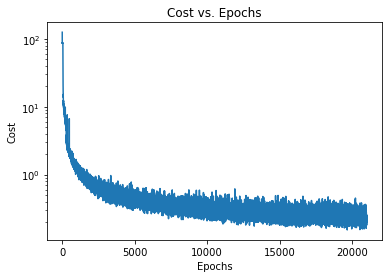

In [14]:
    fig = plt.figure()
    plt.semilogy( epochs, costs )
    plt.xlabel( "Epochs" )
    plt.ylabel( "Cost" )
    plt.title( "Cost vs. Epochs")
    plt.show()
    fig.savefig('CostVsEpochs.png', bbox_inches='tight')

In [15]:
pred_y

array([[ 25.59165955],
       [ 33.42314911],
       [ 18.8982563 ],
       [ 24.38710213],
       [ 18.52455139],
       [ 21.6722393 ],
       [ 21.80138969],
       [ 17.07947922],
       [ 24.52959824],
       [ 20.17720795],
       [ 22.90844345],
       [ 24.3165741 ],
       [  7.59338808],
       [ 23.59096336],
       [ 16.39332008],
       [ 23.17826462],
       [ 21.56837845],
       [  7.95719624],
       [ 45.58715439],
       [ 13.56023979],
       [ 25.93748283],
       [ 30.20636368],
       [ 13.49157524],
       [ 22.6924839 ],
       [ 17.43801117],
       [ 16.34693146],
       [ 21.09925652],
       [ 12.41806316],
       [ 21.95966721],
       [ 20.23654938],
       [ 26.25914574],
       [ 24.62981987],
       [ 23.86974716],
       [ 24.70425034],
       [ 15.38784409],
       [ 18.1137085 ],
       [ 33.61875534],
       [ 18.99781036],
       [ 20.66431618],
       [ 25.35070419],
       [ 15.47408009],
       [ 32.65626526],
       [ 45.73073959],
       [ 18

In [16]:
test_y

array([[ 23.6],
       [ 32.4],
       [ 13.6],
       [ 22.8],
       [ 16.1],
       [ 20. ],
       [ 17.8],
       [ 14. ],
       [ 19.6],
       [ 16.8],
       [ 21.5],
       [ 18.9],
       [  7. ],
       [ 21.2],
       [ 18.5],
       [ 29.8],
       [ 18.8],
       [ 10.2],
       [ 50. ],
       [ 14.1],
       [ 25.2],
       [ 29.1],
       [ 12.7],
       [ 22.4],
       [ 14.2],
       [ 13.8],
       [ 20.3],
       [ 14.9],
       [ 21.7],
       [ 18.3],
       [ 23.1],
       [ 23.8],
       [ 15. ],
       [ 20.8],
       [ 19.1],
       [ 19.4],
       [ 34.7],
       [ 19.5],
       [ 24.4],
       [ 23.4],
       [ 19.7],
       [ 28.2],
       [ 50. ],
       [ 17.4],
       [ 22.6],
       [ 15.1],
       [ 13.1],
       [ 24.2],
       [ 19.9],
       [ 24. ],
       [ 18.9],
       [ 35.4],
       [ 15.2],
       [ 26.5],
       [ 43.5],
       [ 21.2],
       [ 18.4],
       [ 28.5],
       [ 23.9],
       [ 18.5],
       [ 25. ],
       [ 35.4],
       [

In [27]:
20000*20

400000